<a href="https://colab.research.google.com/github/vikpy/MLASem3/blob/master/MLA_Assignment_3_D005.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Car or Truck classifier 

In [54]:
# Making directories for the train set 
!mkdir /content/train 
!mkdir /content/train/car 
!mkdir /content/train/truck 
!mkdir /content/validation 
!mkdir /content/validation/car 
!mkdir /content/validation/truck 

# making directories for the test set 
!mkdir /content/test/ 
!mkdir /content/test/test 

mkdir: cannot create directory ‘/content/train’: File exists
mkdir: cannot create directory ‘/content/train/car’: File exists
mkdir: cannot create directory ‘/content/train/truck’: File exists
mkdir: cannot create directory ‘/content/validation’: File exists
mkdir: cannot create directory ‘/content/validation/car’: File exists
mkdir: cannot create directory ‘/content/validation/truck’: File exists
mkdir: cannot create directory ‘/content/test/’: File exists
mkdir: cannot create directory ‘/content/test/test’: File exists


In [81]:
!cp '/content/drive/My Drive/data assignment/car/'* /content/train/car 

In [82]:
!cp '/content/drive/My Drive/data assignment/validation/car/'* /content/validation/car 

In [83]:
!cp '/content/drive/My Drive/data assignment/truck/'* /content/train/truck 

In [84]:
!cp '/content/drive/My Drive/data assignment/validation/truck/'* /content/validation/truck 

In [85]:
!cp '/content/drive/My Drive/data assignment/test/test/'* /content/test/test/ 

#**Fetching and Labelling the Image Data**

We fetch the data and label the data as per the requirements 


In [86]:
import os
import cv2
import numpy as np
from sklearn.preprocessing import LabelEncoder

def label_data(directory, vehicles, target_size = (224,224)):
  images = []
  vehicle_types = []
  for vehicle in vehicles:
    dir = directory + '/' + vehicle
    files = [dir + '/' + filename for filename in os.listdir(dir)]
    #print(car_files)
    for filename in files:
      if filename.endswith('jpg'):
        try:
          images.append(cv2.resize(cv2.imread(filename), target_size , interpolation=cv2.INTER_CUBIC))
          vehicle_types.append(vehicle)
        except Exception as e:
          print(str(e))
  return np.array(images), LabelEncoder().fit_transform(np.array(vehicle_types)).reshape(len(images), 1)

# Fetching the images from the directory
images_train, labels_train = label_data('/content/train', ["car","truck"])
images_validation, labels_validation = label_data('/content/validation', ["car","truck"])
images_test, _ = label_data('/content/test', ["test"])

OpenCV(4.1.2) /io/opencv/modules/imgproc/src/resize.cpp:3720: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

OpenCV(4.1.2) /io/opencv/modules/imgproc/src/resize.cpp:3720: error: (-215:Assertion failed) !ssize.empty() in function 'resize'



#**Applying some image augmentation**

In [290]:
from keras.preprocessing.image import ImageDataGenerator



trainval_datagen = ImageDataGenerator(
    rescale=1./255, 
    horizontal_flip=True ,
 #   rotation_range=180,
 #   width_shift_range=0.3,
 #   height_shift_range=0.3,
 #   shear_range=0.4,
 #   zoom_range=0.4,
 #  fill_mode = 'nearest',
 #zca_whitening=True
 
)



test_datagen = ImageDataGenerator(
    rescale=1./255
)

# Flowing the data from the directory 
batch_size = 32

train_generator = trainval_datagen.flow(
                                        images_train,
                                        labels_train,             
                                        shuffle=True,
                                        seed=123,
                                        batch_size=batch_size
                  )


validation_generator = trainval_datagen.flow(  
                                          images_validation,
                                          labels_validation,
                                          shuffle=True,
                                          seed=123,                                                                                                        
                                          batch_size=batch_size
                      )



In [88]:
# Path to the train folder
import os
import pandas as pd

original_test = '/content/test/test'
 
filenames = os.listdir(original_test)
categories = []
for filename in filenames:
    category = filename.split('_')[0]
    if category == 'car':
        categories.append(0)
    elif category == 'truck' :
        categories.append(1)

data_test = pd.DataFrame({'filename':filenames,'label':categories})

data_test.to_csv("original_test.csv",index=False)

In [89]:
data_test.head(3)

,filename,label
0,truck_9.jpg,1
1,car_8.jpg,0
2,truck_19.jpg,1


In [90]:
test_generator = test_datagen.flow(
                            images_test ,
                           data_test.label.values                                             
                    )

In [91]:
print(f"Number of Training images: {train_generator.n}")
print(f"Number of Validation images: {validation_generator.n}")
print(f"Number of test images: {test_generator.n}")


Number of Training images: 588
Number of Validation images: 60
Number of test images: 40


#Developing a basic 1 layered CNN model for the model 

In [259]:
from keras.models import Sequential
from keras.layers import Conv2D, Flatten, Dense
from keras.optimizers import SGD
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense, BatchNormalization, ReLU
from keras.callbacks import ModelCheckpoint, EarlyStopping
import keras

# Callback for early stopping
callback = keras.callbacks.EarlyStopping(monitor='loss', patience=20)

# Learning rate decay schedule 
# lr_schedule = keras.optimizers.schedules.ExponentialDecay(
#     initial_learning_rate=1e-1,
#     decay_steps=1000,
#     decay_rate=0.8)
# opt = keras.optimizers.Adam(learning_rate=lr_schedule)

# Building the model 
model = Sequential()

model.add(Conv2D(16, 5, padding='same', activation='relu', input_shape=(224,224,3)))

model.add(MaxPooling2D((3,3)))

model.add(Flatten())

model.add(BatchNormalization())

model.add(Dense(128, activation='relu'))

model.add(Dropout(0.2))

model.add(Dense(64, activation='relu'))

model.add(Dropout(0.2))

model.add(Dense(32, activation='relu'))

model.add(Dropout(0.2))

model.add(Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_28"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_621 (Conv2D)          (None, 224, 224, 16)      1216      
_________________________________________________________________
max_pooling2d_139 (MaxPoolin (None, 74, 74, 16)        0         
_________________________________________________________________
flatten_38 (Flatten)         (None, 87616)             0         
_________________________________________________________________
batch_normalization_56 (Batc (None, 87616)             350464    
_________________________________________________________________
dense_128 (Dense)            (None, 128)               11214976  
_________________________________________________________________
dropout_54 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_129 (Dense)            (None, 64)              

In [260]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=["accuracy"])
history = model.fit_generator(
    train_generator, 
    validation_data = validation_generator,
    epochs=100,  
    verbose=1,
    callbacks=[callback]
    )

Epoch 1/100
19/19 [==============================] - 1s 42ms/step - loss: 4.9140 - accuracy: 0.5238 - val_loss: 0.7097 - val_accuracy: 0.5667
Epoch 2/100
19/19 [==============================] - 1s 34ms/step - loss: 2.8544 - accuracy: 0.5986 - val_loss: 0.7671 - val_accuracy: 0.4167
Epoch 3/100
19/19 [==============================] - 1s 33ms/step - loss: 1.6577 - accuracy: 0.5986 - val_loss: 0.8843 - val_accuracy: 0.4500
Epoch 4/100
19/19 [==============================] - 1s 33ms/step - loss: 1.3013 - accuracy: 0.5884 - val_loss: 0.6467 - val_accuracy: 0.5833
Epoch 5/100
19/19 [==============================] - 1s 33ms/step - loss: 0.7636 - accuracy: 0.6548 - val_loss: 0.5624 - val_accuracy: 0.7500
Epoch 6/100
19/19 [==============================] - 1s 34ms/step - loss: 0.6510 - accuracy: 0.7075 - val_loss: 0.6123 - val_accuracy: 0.7500
Epoch 7/100
19/19 [==============================] - 1s 33ms/step - loss: 0.6227 - accuracy: 0.6973 - val_loss: 0.6474 - val_accuracy: 0.6667
Epoch 

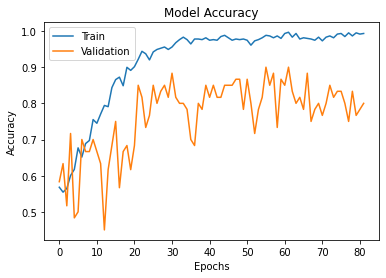

In [98]:
import matplotlib.pyplot as plt
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.title("Model Accuracy for simple ConvNet with 1 layer")
plt.ylabel("Accuracy")
plt.xlabel("Epochs")
plt.legend(["Train", "Validation"], loc="best")
plt.show()

In [99]:
model.evaluate(test_generator)

2/2 [==============================] - 0s 5ms/step - loss: 0.4250 - accuracy: 0.9500


[0.4250330328941345, 0.949999988079071]

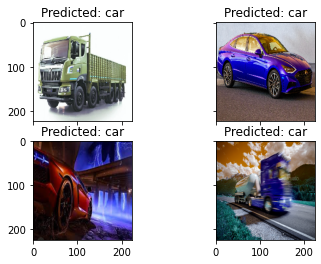

In [261]:
from PIL import Image, ImageFile
from matplotlib.pyplot import imshow
import requests
from io import BytesIO
import numpy as np

images_test, _ = label_data('/content/test1', ["test1"])
pred = model.predict(images_test)

fig, axs = plt.subplots(2, 2)
axs[0, 0].imshow(images_test[0])
axs[0, 0].set_title(f"Predicted: {'car' if pred[0] == 0 else 'truck'}")
axs[0, 1].imshow(images_test[1])
axs[0, 1].set_title(f"Predicted: {'car' if pred[1] == 0 else 'truck'}")
axs[1, 0].imshow(images_test[2])
axs[1, 0].set_title(f"Predicted: {'car' if pred[2] == 0 else 'truck'}")
axs[1, 1].imshow(images_test[3])
axs[1, 1].set_title(f"Predicted: {'car' if pred[2] == 0 else 'truck'}")
for ax in fig.get_axes():
    ax.label_outer()

# Developing deep Conv Net 
---



In [262]:
from keras.layers import Activation, Dropout, Flatten, Dense, BatchNormalization, LeakyReLU, Input

def conv_layers(layer_in, num_layers, filters=6, kernel=(5,5), stride=(1,1), padding='valid'):
  for layer in range(num_layers):
    layer_in = Conv2D(filters=filters, kernel_size=kernel, strides=stride, padding=padding)(layer_in)
    layer_in = LeakyReLU(alpha=3e-2)(layer_in)
  layer_in = MaxPooling2D(pool_size=(3,3))(layer_in)
  return layer_in   

In [285]:
from keras.models import Model 
from keras.layers import Input, Conv2D, MaxPooling2D, Dense, Flatten, BatchNormalization



# Callback for early stopping
callback = keras.callbacks.EarlyStopping(monitor='loss', patience=20)
input_layer = Input(shape=(224,224,3))
layer = conv_layers(input_layer,1, 8, (64,64))
layer = BatchNormalization()(layer)
layer = conv_layers(input_layer,1, 4, (32, 32))
layer = BatchNormalization()(layer)
layer = Flatten()(layer)
layer = Dense(128, activation='relu')(layer)
layer = Dropout(0.2)(layer)
layer = Dense(64, activation='relu')(layer)
layer = Dropout(0.2)(layer)
layer = Dense(1, activation='sigmoid')(layer)
model = Model(inputs=input_layer, outputs=layer)
model.summary()


Model: "functional_66"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_63 (InputLayer)        [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv2d_625 (Conv2D)          (None, 193, 193, 4)       12292     
_________________________________________________________________
leaky_re_lu_609 (LeakyReLU)  (None, 193, 193, 4)       0         
_________________________________________________________________
max_pooling2d_143 (MaxPoolin (None, 64, 64, 4)         0         
_________________________________________________________________
batch_normalization_66 (Batc (None, 64, 64, 4)         16        
_________________________________________________________________
flatten_43 (Flatten)         (None, 16384)             0         
_________________________________________________________________
dense_144 (Dense)            (None, 128)             

In [286]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=["accuracy"])
history = model.fit_generator(
    train_generator, 
    validation_data = validation_generator,
    epochs=40,  
    verbose=1,
    callbacks=[callback]
    )

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:739: UserWarning: This ImageDataGenerator specifies `zca_whitening`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


Epoch 1/40
19/19 [==============================] - 1s 39ms/step - loss: 1.7308 - accuracy: 0.4949 - val_loss: 14.2251 - val_accuracy: 0.4500
Epoch 2/40
19/19 [==============================] - 1s 31ms/step - loss: 1.3691 - accuracy: 0.5918 - val_loss: 10.6095 - val_accuracy: 0.4667
Epoch 3/40
19/19 [==============================] - 1s 31ms/step - loss: 1.5996 - accuracy: 0.6003 - val_loss: 5.9132 - val_accuracy: 0.4167
Epoch 4/40
19/19 [==============================] - 1s 33ms/step - loss: 1.3110 - accuracy: 0.6156 - val_loss: 0.8176 - val_accuracy: 0.6500
Epoch 5/40
19/19 [==============================] - 1s 32ms/step - loss: 1.0322 - accuracy: 0.6207 - val_loss: 7.5904 - val_accuracy: 0.4333
Epoch 6/40
19/19 [==============================] - 1s 31ms/step - loss: 0.9086 - accuracy: 0.6446 - val_loss: 4.0559 - val_accuracy: 0.4500
Epoch 7/40
19/19 [==============================] - 1s 31ms/step - loss: 0.7247 - accuracy: 0.6735 - val_loss: 0.7721 - val_accuracy: 0.6500
Epoch 8/40


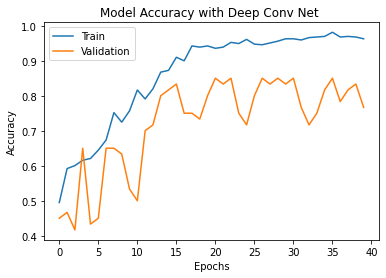

In [287]:
import matplotlib.pyplot as plt
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.title("Model Accuracy with Deep Conv Net ")
plt.ylabel("Accuracy")
plt.xlabel("Epochs")
plt.legend(["Train", "Validation"], loc="best")
plt.show()

In [288]:
model.evaluate(test_generator)

2/2 [==============================] - 0s 4ms/step - loss: 0.4281 - accuracy: 0.8250


[0.4280514121055603, 0.824999988079071]

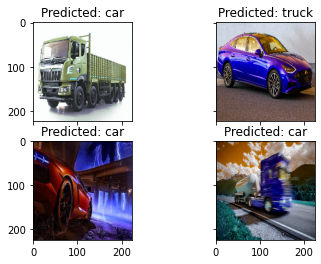

In [289]:
from PIL import Image, ImageFile
from matplotlib.pyplot import imshow
import requests
from io import BytesIO
import numpy as np

images_test, _ = label_data('/content/test1', ["test1"])
pred = model.predict(images_test)

fig, axs = plt.subplots(2, 2)
axs[0, 0].imshow(images_test[0])
axs[0, 0].set_title(f"Predicted: {'car' if pred[0] == 0 else 'truck'}")
axs[0, 1].imshow(images_test[1])
axs[0, 1].set_title(f"Predicted: {'car' if pred[1] == 0 else 'truck'}")
axs[1, 0].imshow(images_test[2])
axs[1, 0].set_title(f"Predicted: {'car' if pred[2] == 0 else 'truck'}")
axs[1, 1].imshow(images_test[3])
axs[1, 1].set_title(f"Predicted: {'car' if pred[2] == 0 else 'truck'}")
for ax in fig.get_axes():
    ax.label_outer()

#Using Pretrained VGG16 Architecture with 2 more dense layers for the model  

In [269]:
import keras as keras

callback = keras.callbacks.EarlyStopping(monitor='loss', patience=20)


base_model = keras.applications.VGG16(
    weights='imagenet',  # Load weights pre-trained on ImageNet.
    input_shape=(224, 224, 3),
    include_top=False)  # 

base_model.trainable = False

input_layer = keras.Input(shape=(224, 224, 3))
x = base_model(input_layer, training=False)
# Convert features of shape `base_model.output_shape[1:]` to vectors
layer = Flatten()(x)
layer = Dense(1024, activation='relu')(layer)
layer = Dropout(0.2)(layer)
layer = Dense(512, activation='relu')(layer)
layer = Dropout(0.2)(layer)
layer = Dense(1, activation='sigmoid')(layer)
model = Model(inputs=input_layer, outputs=layer)
model.summary()

Model: "functional_60"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_58 (InputLayer)        [(None, 224, 224, 3)]     0         
_________________________________________________________________
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_40 (Flatten)         (None, 25088)             0         
_________________________________________________________________
dense_135 (Dense)            (None, 1024)              25691136  
_________________________________________________________________
dropout_59 (Dropout)         (None, 1024)              0         
_________________________________________________________________
dense_136 (Dense)            (None, 512)               524800    
_________________________________________________________________
dropout_60 (Dropout)         (None, 512)             

In [270]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=["accuracy"])
history = model.fit_generator(
    train_generator, 
    validation_data = validation_generator,
    epochs=40,  
    verbose=1,
    callbacks=[callback]
    )

Epoch 1/40
19/19 [==============================] - 3s 151ms/step - loss: 2.1688 - accuracy: 0.5867 - val_loss: 0.3699 - val_accuracy: 0.8667
Epoch 2/40
19/19 [==============================] - 3s 141ms/step - loss: 0.5238 - accuracy: 0.7789 - val_loss: 0.3221 - val_accuracy: 0.8500
Epoch 3/40
19/19 [==============================] - 3s 143ms/step - loss: 0.2479 - accuracy: 0.9031 - val_loss: 0.1930 - val_accuracy: 0.9167
Epoch 4/40
19/19 [==============================] - 3s 144ms/step - loss: 0.1732 - accuracy: 0.9235 - val_loss: 0.1527 - val_accuracy: 0.9333
Epoch 5/40
19/19 [==============================] - 3s 146ms/step - loss: 0.1101 - accuracy: 0.9558 - val_loss: 0.1724 - val_accuracy: 0.9333
Epoch 6/40
19/19 [==============================] - 3s 147ms/step - loss: 0.1470 - accuracy: 0.9558 - val_loss: 0.2076 - val_accuracy: 0.8833
Epoch 7/40
19/19 [==============================] - 3s 148ms/step - loss: 0.1308 - accuracy: 0.9592 - val_loss: 0.1502 - val_accuracy: 0.8833
Epoch 

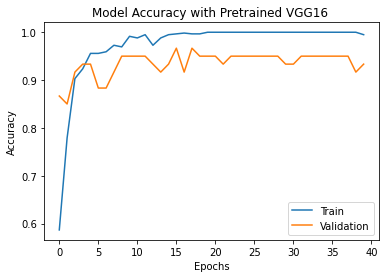

In [271]:
import matplotlib.pyplot as plt
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.title("Model Accuracy with Pretrained VGG16 ")
plt.ylabel("Accuracy")
plt.xlabel("Epochs")
plt.legend(["Train", "Validation"], loc="best")
plt.show()

In [272]:
model.evaluate(test_generator)

2/2 [==============================] - 0s 29ms/step - loss: 0.0042 - accuracy: 1.0000


[0.004205509088933468, 1.0]

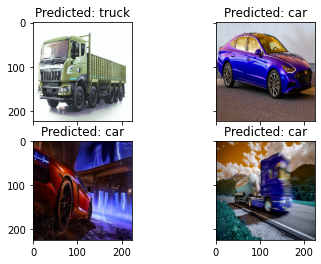

In [273]:
from PIL import Image, ImageFile
from matplotlib.pyplot import imshow
import requests
from io import BytesIO
import numpy as np

images_test, _ = label_data('/content/test1', ["test1"])
pred = model.predict(images_test)

fig, axs = plt.subplots(2, 2)
axs[0, 0].imshow(images_test[0])
axs[0, 0].set_title(f"Predicted: {'car' if pred[0] == 0 else 'truck'}")
axs[0, 1].imshow(images_test[1])
axs[0, 1].set_title(f"Predicted: {'car' if pred[1] == 0 else 'truck'}")
axs[1, 0].imshow(images_test[2])
axs[1, 0].set_title(f"Predicted: {'car' if pred[2] == 0 else 'truck'}")
axs[1, 1].imshow(images_test[3])
axs[1, 1].set_title(f"Predicted: {'car' if pred[2] == 0 else 'truck'}")
for ax in fig.get_axes():
    ax.label_outer()

#Using Pretrained VGG19 Architecture with 2 more dense layers for the model  

In [291]:
import keras as keras

callback = keras.callbacks.EarlyStopping(monitor='loss', patience=20)


base_model = keras.applications.VGG19(
    weights='imagenet',  # Load weights pre-trained on ImageNet.
    input_shape=(224, 224, 3),
    include_top=False)  # 

base_model.trainable = False

input_layer = keras.Input(shape=(224, 224, 3))
x = base_model(input_layer, training=False)
# Convert features of shape `base_model.output_shape[1:]` to vectors
layer = Flatten()(x)
layer = BatchNormalization()(layer)
layer = Dense(1024, activation='relu')(layer)
layer = BatchNormalization()(layer)
layer = Dropout(0.2)(layer)
layer = Dense(512, activation='relu')(layer)
layer = BatchNormalization()(layer)
layer = Dropout(0.2)(layer)
layer = Dense(1, activation='sigmoid')(layer)
model = Model(inputs=input_layer, outputs=layer)
model.summary()

Model: "functional_68"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_65 (InputLayer)        [(None, 224, 224, 3)]     0         
_________________________________________________________________
vgg19 (Functional)           (None, 7, 7, 512)         20024384  
_________________________________________________________________
flatten_44 (Flatten)         (None, 25088)             0         
_________________________________________________________________
batch_normalization_67 (Batc (None, 25088)             100352    
_________________________________________________________________
dense_147 (Dense)            (None, 1024)              25691136  
_________________________________________________________________
batch_normalization_68 (Batc (None, 1024)              4096      
_________________________________________________________________
dropout_67 (Dropout)         (None, 1024)            

In [292]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=["accuracy"])
history = model.fit_generator(
    train_generator, 
    validation_data = validation_generator,
    epochs=40,  
    verbose=1,
    callbacks=[callback]
    )

Epoch 1/40
19/19 [==============================] - 3s 180ms/step - loss: 0.7648 - accuracy: 0.7636 - val_loss: 3.3059 - val_accuracy: 0.5833
Epoch 2/40
19/19 [==============================] - 3s 172ms/step - loss: 0.2964 - accuracy: 0.8963 - val_loss: 1.8028 - val_accuracy: 0.6500
Epoch 3/40
19/19 [==============================] - 3s 174ms/step - loss: 0.1012 - accuracy: 0.9609 - val_loss: 1.2882 - val_accuracy: 0.7000
Epoch 4/40
19/19 [==============================] - 3s 175ms/step - loss: 0.0784 - accuracy: 0.9762 - val_loss: 0.7703 - val_accuracy: 0.7833
Epoch 5/40
19/19 [==============================] - 3s 177ms/step - loss: 0.0383 - accuracy: 0.9830 - val_loss: 0.5521 - val_accuracy: 0.8333
Epoch 6/40
19/19 [==============================] - 3s 179ms/step - loss: 0.0357 - accuracy: 0.9881 - val_loss: 0.3155 - val_accuracy: 0.8833
Epoch 7/40
19/19 [==============================] - 3s 179ms/step - loss: 0.0197 - accuracy: 0.9949 - val_loss: 0.2204 - val_accuracy: 0.9167
Epoch 

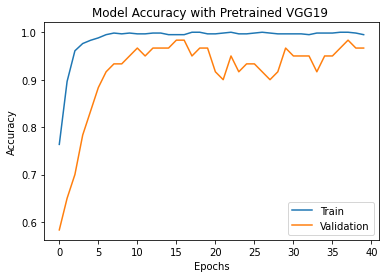

In [295]:
import matplotlib.pyplot as plt
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.title("Model Accuracy with Pretrained VGG19 ")
plt.ylabel("Accuracy")
plt.xlabel("Epochs")
plt.legend(["Train", "Validation"], loc="best")
plt.show()

In [296]:
model.evaluate(test_generator)

2/2 [==============================] - 0s 33ms/step - loss: 0.0879 - accuracy: 0.9500


[0.08786401897668839, 0.949999988079071]

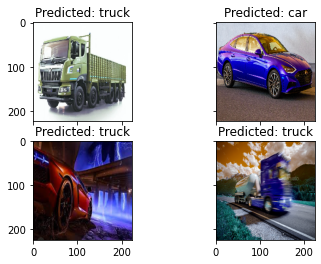

In [298]:
from PIL import Image, ImageFile
from matplotlib.pyplot import imshow
import requests
from io import BytesIO
import numpy as np

images_test, _ = label_data('/content/test1', ["test1"])
pred = model.predict(images_test)

fig, axs = plt.subplots(2, 2)
axs[0, 0].imshow(images_test[0])
axs[0, 0].set_title(f"Predicted: {'car' if pred[0] == 0 else 'truck'}")
axs[0, 1].imshow(images_test[1])
axs[0, 1].set_title(f"Predicted: {'car' if pred[1] == 0 else 'truck'}")
axs[1, 0].imshow(images_test[2])
axs[1, 0].set_title(f"Predicted: {'car' if pred[2] == 0 else 'truck'}")
axs[1, 1].imshow(images_test[3])
axs[1, 1].set_title(f"Predicted: {'car' if pred[2] == 0 else 'truck'}")
for ax in fig.get_axes():
    ax.label_outer()